<a href="https://colab.research.google.com/github/djiraffs/Deep-Learning/blob/main/Week%205/Tugas_Week_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# ======= Hyperparams =======
epochs = 10

num_words = 15000
maxlen = 200  # Adjusted for shorter reviews
batch_size = 64
embedding_dim = 128  # Reduced since clothing reviews are typically shorter
hidden_dim = 128
num_layers = 2
dropout_prob = 0.15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======= Load & Preprocess =======
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        text = ' '.join([w for w in word_tokens if w not in stop_words])
        return text
    else:
        return ""  # Return empty string for NaN values

# Load the dataset
df = pd.read_csv('ReviewTokoBaju.csv')

# Check if the dataset has the expected columns
print("Dataset columns:", df.columns.tolist())

# For this example, let's assume the dataset has 'Review Text' and 'Rating' columns
# Adjust these names according to your actual dataset column names
review_col = 'Review Text'
rating_col = 'Rating'

# Handle missing values
df[review_col] = df[review_col].fillna("")

# Preprocess reviews
df['processed_review'] = df[review_col].apply(preprocess_text)

# Convert ratings to binary sentiment (positive/negative)
# Assuming ratings are on a scale (e.g., 1-5), set threshold at midpoint
rating_threshold = 3
df['sentiment'] = (df[rating_col] > rating_threshold).astype(int)

# Build vocabulary from the dataset
def build_vocab(texts, max_words=num_words):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    # Sort words by frequency
    vocab = {word: idx+1 for idx, (word, _) in
             enumerate(word_counts.most_common(max_words-1))}
    # Add padding token
    vocab['<PAD>'] = 0
    return vocab

# Create vocabulary
vocabulary = build_vocab(df['processed_review'].tolist(), max_words=num_words)
vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}")

# Convert texts to sequences
def text_to_sequence(text, vocab, maxlen):
    words = text.split()
    sequence = [vocab.get(word, 0) for word in words]  # Use 0 for OOV words
    # Pad or truncate to maxlen
    if len(sequence) > maxlen:
        sequence = sequence[:maxlen]
    else:
        sequence = sequence + [0] * (maxlen - len(sequence))
    return sequence

# Create sequences
df['sequence'] = df['processed_review'].apply(lambda x: text_to_sequence(x, vocabulary, maxlen))

# Split data
X = np.array(df['sequence'].tolist())
y = np.array(df['sentiment'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create PyTorch datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"vocab_size: {vocab_size}, maxlen: {maxlen}, Using device: {device}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Dataset columns: ['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name']
Vocabulary size: 15000
vocab_size: 15000, maxlen: 200, Using device: cuda


# Model RNN

Epoch 1: Train Accuracy=0.8173, Test Accuracy=0.8218 | Train Loss=0.4274, Test Loss=0.3831
Epoch 2: Train Accuracy=0.8829, Test Accuracy=0.8702 | Train Loss=0.2910, Test Loss=0.3099
Epoch 3: Train Accuracy=0.9082, Test Accuracy=0.8668 | Train Loss=0.2371, Test Loss=0.3181
Epoch 4: Train Accuracy=0.9254, Test Accuracy=0.8644 | Train Loss=0.2002, Test Loss=0.3249
Epoch 5: Train Accuracy=0.9522, Test Accuracy=0.8640 | Train Loss=0.1369, Test Loss=0.3657
Epoch 6: Train Accuracy=0.9699, Test Accuracy=0.8585 | Train Loss=0.0960, Test Loss=0.4190
Epoch 7: Train Accuracy=0.9842, Test Accuracy=0.8525 | Train Loss=0.0566, Test Loss=0.5141
Epoch 8: Train Accuracy=0.9895, Test Accuracy=0.8525 | Train Loss=0.0415, Test Loss=0.5833
Epoch 9: Train Accuracy=0.9923, Test Accuracy=0.8495 | Train Loss=0.0303, Test Loss=0.6022
Epoch 10: Train Accuracy=0.9936, Test Accuracy=0.8508 | Train Loss=0.0253, Test Loss=0.6528

Final Evaluation on Test Set:
Accuracy : 0.8508
Precision: 0.8923
Recall   : 0.9163
F1 S

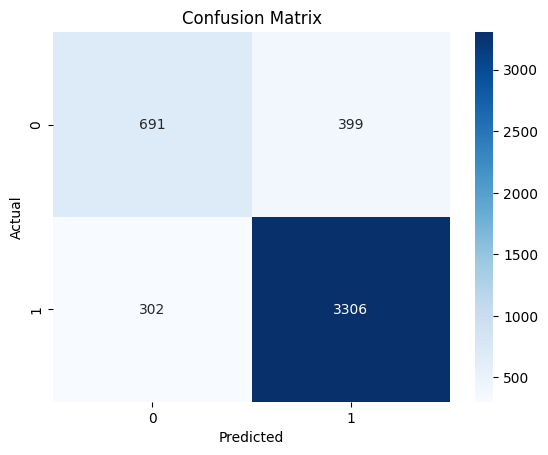

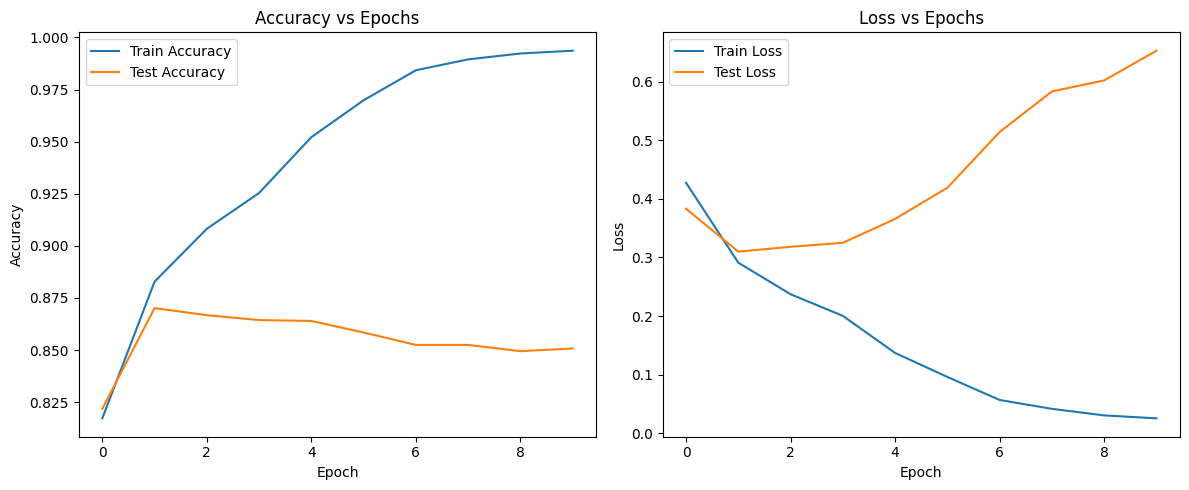

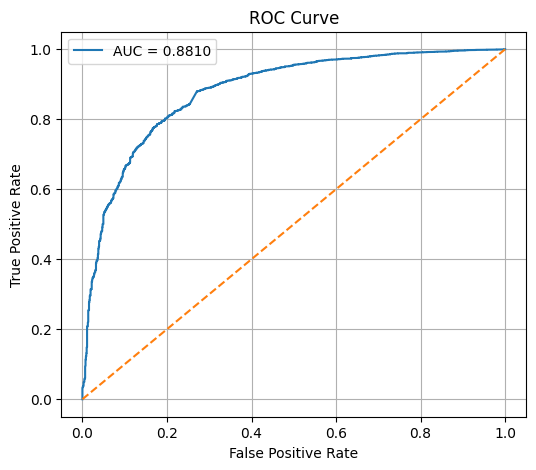


Information:
 1 : Recommended
 0 : Not Recommended


Sample Predictions:
1. Text: agree reviewer color isnt pink person subtle thoughts things __________ pros pockets makes fun chic ...
   True: 1, Pred: 1, Prob: 0.9795

2. Text: many sweaters bought sale soft comfortable...
   True: 1, Pred: 1, Prob: 0.9982

3. Text: beautiful top runs whole size small gave daughter loved...
   True: 1, Pred: 1, Prob: 0.9894

4. Text: loved pantsthey comfortable however wearing twice threads leaves fraying leaving lint whatever sit l...
   True: 0, Pred: 0, Prob: 0.0003

5. Text: ordered dress petite arrived regular rest fit meantime petites ran size dress long beautiful get sho...
   True: 1, Pred: 1, Prob: 0.9992

6. Text: cute shirt picked whitewithflowers shown online yet straight white looks like could wrinkle definite...
   True: 1, Pred: 1, Prob: 0.9941

7. Text: send back exchange way big im excited get smaller size really beautifully made...
   True: 0, Pred: 0, Prob: 0.0140

8. Text: liked 

In [12]:
class RNN_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.4):
        super(RNN_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()

        # Initialize weights for better convergence
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'embedding' in name:
                nn.init.uniform_(param, -0.1, 0.1)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # x shape: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]

        # RNN forward pass
        output, _ = self.rnn(embedded)  # [batch, seq_len, hidden_dim]

        # Global max pooling
        pooled, _ = torch.max(output, dim=1)  # [batch, hidden_dim]

        # Apply dropout before final layer
        pooled = self.dropout(pooled)

        # Final classification layer
        logits = self.fc(pooled).squeeze(1)  # [batch]
        return self.activation(logits)

# Initialize model, loss, and optimizer
model = RNN_Model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# ======= Train & Evaluate =======
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            total_loss += loss.item()

            preds = (probs >= 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return total_loss / len(loader), y_true, y_pred, y_prob

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward pass
        probs = model(x)
        loss = criterion(probs, y)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        preds = (probs >= 0.5).int()
        correct += (preds == y.int()).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Evaluate on test set
    test_loss, y_true, y_pred, y_prob = evaluate(model, test_loader, criterion)
    test_loss_hist.append(test_loss)
    test_acc = accuracy_score(y_true, y_pred)
    test_acc_hist.append(test_acc)

    # Update scheduler based on validation loss
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f} | Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

# ======= Metrics =======
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {test_acc_hist[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ======= Visualization =======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()

# ======= ROC Curve =======
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ======= Inspect some predictions =======
def get_sample_predictions(model, loader, n_samples=10):
    model.eval()
    samples = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            preds = (probs >= 0.5).int()

            for i in range(min(n_samples, len(x))):
                # Get the original text
                seq = x[i].cpu().numpy()
                # Convert sequence back to text
                idx_to_word = {idx: word for word, idx in vocabulary.items()}
                words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
                text = ' '.join(words)

                samples.append({
                    'text': text[:100] + '...',  # First 100 chars
                    'true': y[i].item(),
                    'pred': preds[i].item(),
                    'prob': probs[i].item()
                })

            if len(samples) >= n_samples:
                break

    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions(model, test_loader)
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()

# Model LSTM

Epoch 1: Train Accuracy=0.8199, Test Accuracy=0.8642 | Train Loss=0.4275, Test Loss=0.3074
Epoch 2: Train Accuracy=0.8882, Test Accuracy=0.8672 | Train Loss=0.2738, Test Loss=0.2984
Epoch 3: Train Accuracy=0.9137, Test Accuracy=0.8691 | Train Loss=0.2254, Test Loss=0.3032
Epoch 4: Train Accuracy=0.9295, Test Accuracy=0.8668 | Train Loss=0.1887, Test Loss=0.3258
Epoch 5: Train Accuracy=0.9518, Test Accuracy=0.8612 | Train Loss=0.1386, Test Loss=0.3607
Epoch 6: Train Accuracy=0.9605, Test Accuracy=0.8593 | Train Loss=0.1172, Test Loss=0.4160
Epoch 7: Train Accuracy=0.9694, Test Accuracy=0.8593 | Train Loss=0.0933, Test Loss=0.4483
Epoch 8: Train Accuracy=0.9731, Test Accuracy=0.8576 | Train Loss=0.0837, Test Loss=0.5112
Epoch 9: Train Accuracy=0.9758, Test Accuracy=0.8576 | Train Loss=0.0729, Test Loss=0.5883
Epoch 10: Train Accuracy=0.9786, Test Accuracy=0.8567 | Train Loss=0.0677, Test Loss=0.5879

Final Evaluation on Test Set:
Accuracy : 0.8567
Precision: 0.8908
Recall   : 0.9271
F1 S

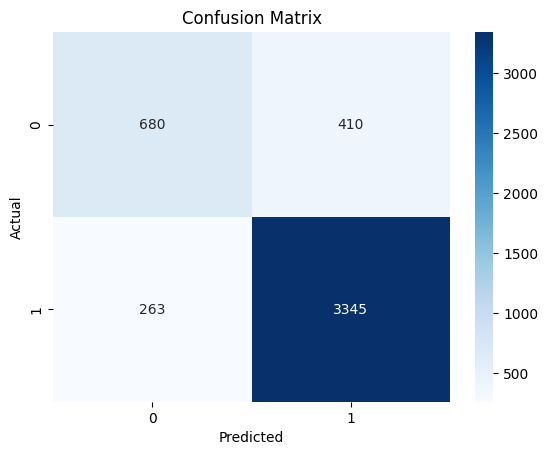

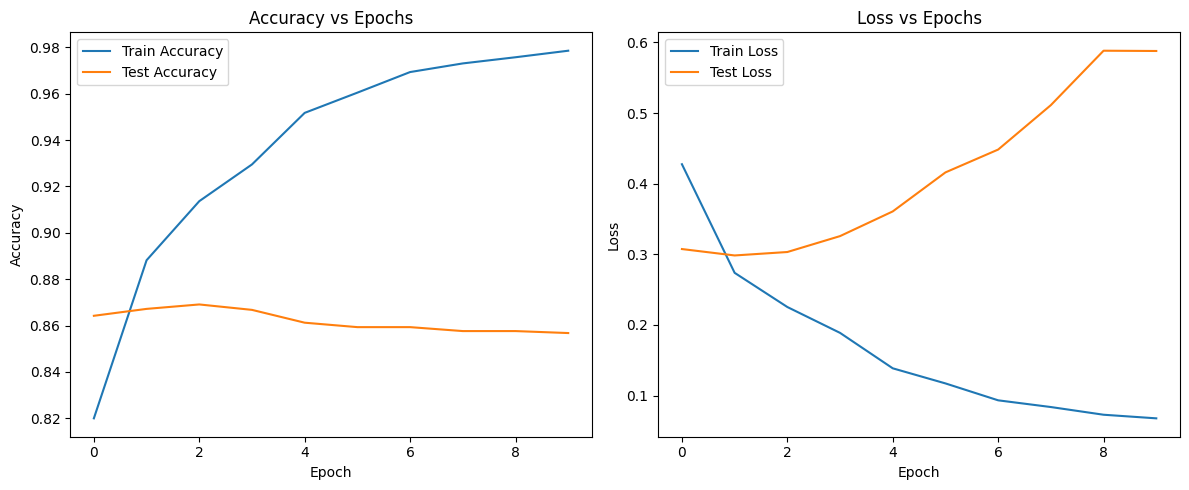

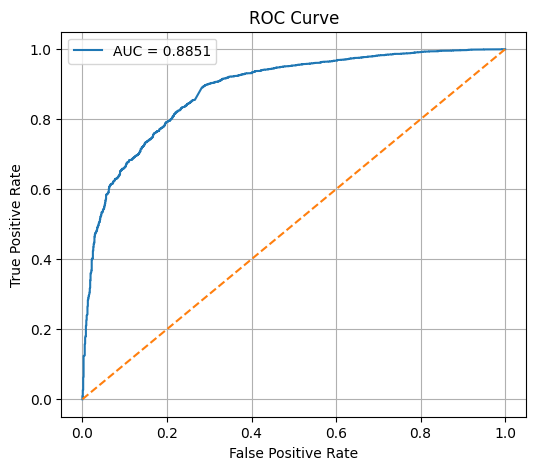


Information:
 1 : Recommended
 0 : Not Recommended


Sample Predictions:
1. Text: agree reviewer color isnt pink person subtle thoughts things __________ pros pockets makes fun chic ...
   True: 1, Pred: 1, Prob: 0.9981

2. Text: many sweaters bought sale soft comfortable...
   True: 1, Pred: 1, Prob: 0.9644

3. Text: beautiful top runs whole size small gave daughter loved...
   True: 1, Pred: 1, Prob: 0.9064

4. Text: loved pantsthey comfortable however wearing twice threads leaves fraying leaving lint whatever sit l...
   True: 0, Pred: 0, Prob: 0.0014

5. Text: ordered dress petite arrived regular rest fit meantime petites ran size dress long beautiful get sho...
   True: 1, Pred: 1, Prob: 0.9999

6. Text: cute shirt picked whitewithflowers shown online yet straight white looks like could wrinkle definite...
   True: 1, Pred: 1, Prob: 0.9998

7. Text: send back exchange way big im excited get smaller size really beautifully made...
   True: 0, Pred: 0, Prob: 0.0385

8. Text: liked 

In [13]:
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.4):
        super(LSTM_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()

        # Initialize weights for better convergence
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'embedding' in name:
                nn.init.uniform_(param, -0.1, 0.1)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # x shape: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]

        # LSTM forward pass
        output, _ = self.lstm(embedded)  # [batch, seq_len, hidden_dim]

        # Global max pooling
        pooled, _ = torch.max(output, dim=1)  # [batch, hidden_dim]

        # Apply dropout before final layer
        pooled = self.dropout(pooled)

        # Final classification layer
        logits = self.fc(pooled).squeeze(1)  # [batch]
        return self.activation(logits)

# Initialize model, loss, and optimizer
model = LSTM_Model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# ======= Train & Evaluate =======
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            total_loss += loss.item()

            preds = (probs >= 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return total_loss / len(loader), y_true, y_pred, y_prob

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward pass
        probs = model(x)
        loss = criterion(probs, y)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        preds = (probs >= 0.5).int()
        correct += (preds == y.int()).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Evaluate on test set
    test_loss, y_true, y_pred, y_prob = evaluate(model, test_loader, criterion)
    test_loss_hist.append(test_loss)
    test_acc = accuracy_score(y_true, y_pred)
    test_acc_hist.append(test_acc)

    # Update scheduler based on validation loss
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f} | Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

# ======= Metrics =======
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {test_acc_hist[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ======= Visualization =======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()

# ======= ROC Curve =======
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ======= Inspect some predictions =======
def get_sample_predictions(model, loader, n_samples=10):
    model.eval()
    samples = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            preds = (probs >= 0.5).int()

            for i in range(min(n_samples, len(x))):
                # Get the original text
                seq = x[i].cpu().numpy()
                # Convert sequence back to text
                idx_to_word = {idx: word for word, idx in vocabulary.items()}
                words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
                text = ' '.join(words)

                samples.append({
                    'text': text[:100] + '...',  # First 100 chars
                    'true': y[i].item(),
                    'pred': preds[i].item(),
                    'prob': probs[i].item()
                })

            if len(samples) >= n_samples:
                break

    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions(model, test_loader)
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()

# Model GRU

Epoch 1: Train Accuracy=0.8378, Test Accuracy=0.8591 | Train Loss=0.3794, Test Loss=0.3293
Epoch 2: Train Accuracy=0.8965, Test Accuracy=0.8753 | Train Loss=0.2590, Test Loss=0.2932
Epoch 3: Train Accuracy=0.9150, Test Accuracy=0.8687 | Train Loss=0.2187, Test Loss=0.3098
Epoch 4: Train Accuracy=0.9333, Test Accuracy=0.8702 | Train Loss=0.1792, Test Loss=0.3312
Epoch 5: Train Accuracy=0.9581, Test Accuracy=0.8646 | Train Loss=0.1236, Test Loss=0.3928
Epoch 6: Train Accuracy=0.9682, Test Accuracy=0.8612 | Train Loss=0.0963, Test Loss=0.4426
Epoch 7: Train Accuracy=0.9780, Test Accuracy=0.8561 | Train Loss=0.0707, Test Loss=0.5355
Epoch 8: Train Accuracy=0.9809, Test Accuracy=0.8536 | Train Loss=0.0612, Test Loss=0.5880
Epoch 9: Train Accuracy=0.9848, Test Accuracy=0.8506 | Train Loss=0.0492, Test Loss=0.6479
Epoch 10: Train Accuracy=0.9859, Test Accuracy=0.8508 | Train Loss=0.0455, Test Loss=0.6832

Final Evaluation on Test Set:
Accuracy : 0.8508
Precision: 0.8959
Recall   : 0.9116
F1 S

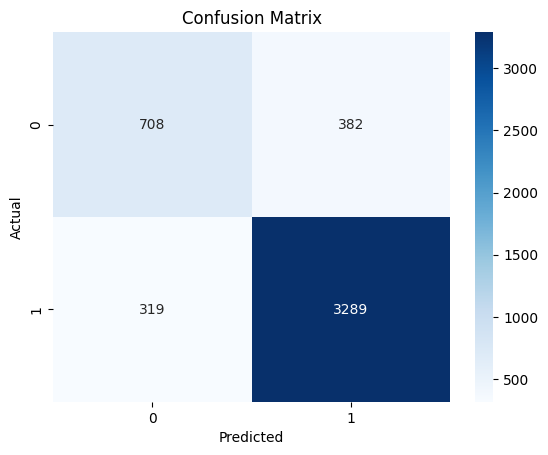

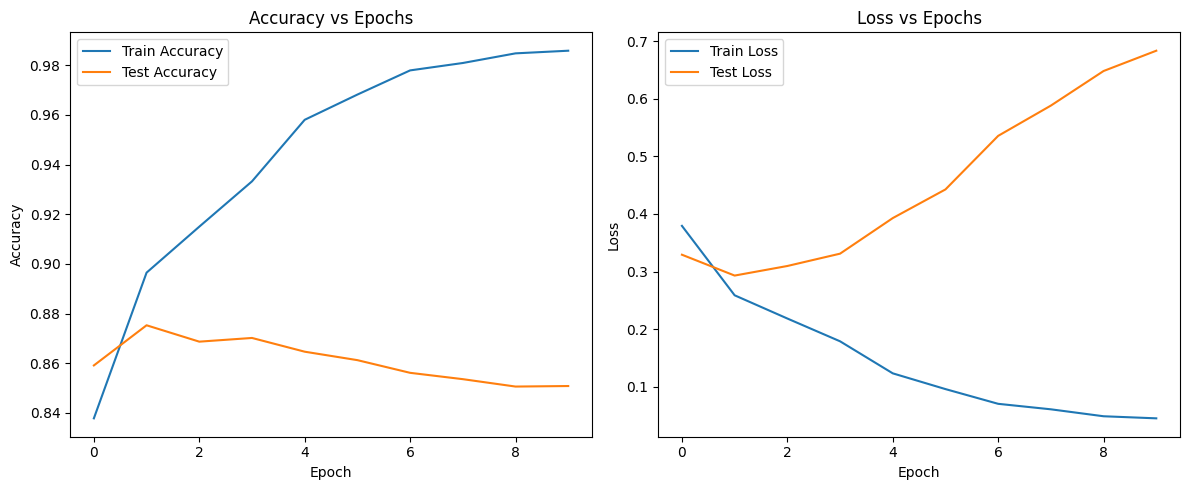

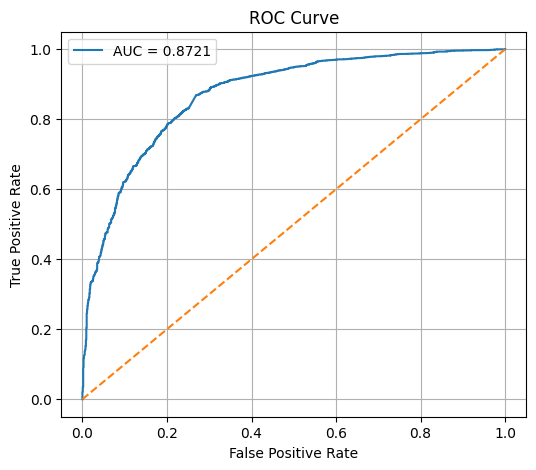


Information:
 1 : Recommended
 0 : Not Recommended


Sample Predictions:
1. Text: agree reviewer color isnt pink person subtle thoughts things __________ pros pockets makes fun chic ...
   True: 1, Pred: 1, Prob: 0.9986

2. Text: many sweaters bought sale soft comfortable...
   True: 1, Pred: 1, Prob: 0.9629

3. Text: beautiful top runs whole size small gave daughter loved...
   True: 1, Pred: 1, Prob: 0.9434

4. Text: loved pantsthey comfortable however wearing twice threads leaves fraying leaving lint whatever sit l...
   True: 0, Pred: 0, Prob: 0.0002

5. Text: ordered dress petite arrived regular rest fit meantime petites ran size dress long beautiful get sho...
   True: 1, Pred: 1, Prob: 0.9999

6. Text: cute shirt picked whitewithflowers shown online yet straight white looks like could wrinkle definite...
   True: 1, Pred: 1, Prob: 0.9829

7. Text: send back exchange way big im excited get smaller size really beautifully made...
   True: 0, Pred: 0, Prob: 0.2060

8. Text: liked 

In [14]:
class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.4):
        super(GRU_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()

        # Initialize weights for better convergence
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'embedding' in name:
                nn.init.uniform_(param, -0.1, 0.1)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # x shape: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]

        # GRU forward pass
        output, _ = self.gru(embedded)  # [batch, seq_len, hidden_dim]

        # Global max pooling
        pooled, _ = torch.max(output, dim=1)  # [batch, hidden_dim]

        # Apply dropout before final layer
        pooled = self.dropout(pooled)

        # Final classification layer
        logits = self.fc(pooled).squeeze(1)  # [batch]
        return self.activation(logits)

# Initialize model, loss, and optimizer
model = GRU_Model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# ======= Train & Evaluate =======
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            total_loss += loss.item()

            preds = (probs >= 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return total_loss / len(loader), y_true, y_pred, y_prob

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward pass
        probs = model(x)
        loss = criterion(probs, y)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        preds = (probs >= 0.5).int()
        correct += (preds == y.int()).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Evaluate on test set
    test_loss, y_true, y_pred, y_prob = evaluate(model, test_loader, criterion)
    test_loss_hist.append(test_loss)
    test_acc = accuracy_score(y_true, y_pred)
    test_acc_hist.append(test_acc)

    # Update scheduler based on validation loss
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f} | Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

# ======= Metrics =======
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {test_acc_hist[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ======= Visualization =======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()

# ======= ROC Curve =======
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ======= Inspect some predictions =======
def get_sample_predictions(model, loader, n_samples=10):
    model.eval()
    samples = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            preds = (probs >= 0.5).int()

            for i in range(min(n_samples, len(x))):
                # Get the original text
                seq = x[i].cpu().numpy()
                # Convert sequence back to text
                idx_to_word = {idx: word for word, idx in vocabulary.items()}
                words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
                text = ' '.join(words)

                samples.append({
                    'text': text[:100] + '...',  # First 100 chars
                    'true': y[i].item(),
                    'pred': preds[i].item(),
                    'prob': probs[i].item()
                })

            if len(samples) >= n_samples:
                break

    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions(model, test_loader)
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()